# Machine Learning for Climate Science Tutorial with Python

## Part 2: Regression with the Lorenz 96 system

In the second part of the *Machine Learning for Climate Science* tutorial, we are going to look at the problem of *statistical regression* using the Lorenz 96 system as a case study. Most of the dicussion in this section comes from this [excellent blog](https://raspstephan.github.io/blog/lorenz-96-is-too-easy/), which you should check out if you want to know more.

The two-level Lorenz 96 model (or L96 for short) is given by the following set of ODEs,

\begin{align*}
\frac{dX_k}{dt} &= -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F - \frac{hc}{J} \sum_{j=1}^J Y_{j,k}, \quad k = 1, \ldots, K \\
\frac1c \frac{dY_{j,k}}{dt} &= -b Y_{j+1, k} (Y_{j+2, k} - Y_{j-1, k}) - Y_{j, k} + \frac{h}{J} X_k, \quad \qquad k = 1, \ldots, K, \quad j = 1, \ldots, J,
\end{align*}

which was originally devised by Edward Lorenz in 1996 as a toy model for extratropical atmosphere. A particular feature of this model is the interaction between the variables $X$, which represent the low-frequency 'slow' motions and the variables $Y$, which represent the high-frequency 'fast' motions.
Thus, the L96 model is a nice playground to test out *parametrization schemes*, which represents the subgrid effects (i.e. the effect that $Y$ has on $X$), as functions of only the slow variables $X$.

In the case of the L96 model, the effect that the fast variables have on the slow variables is given by the term $B_k = - \frac{hc}{J} \sum_{j=1}^J Y_{j,k}$ in the first equation, so we can cast the problem of parametrization as a *statistical regression problem* as follows:

#### Challenge: Find a suitable mapping $f: X \mapsto B$  that best represents the relationship between the slow variables and the subgrid terms.

If we can find such a relationship, then we can use a surrogate model

$$
\frac{dX_k}{dt} = -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F - f_k(X), \quad k = 1, \ldots, K
$$

to approximate the full L96 system with much smaller computational cost, which is our main goal here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
currentdir = os.path.dirname(os.path.realpath('__file__'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from datasets.lorenz import Lorenz96
import time

We integrate the L96 model for $6000$ timesteps (with stepsize $\Delta t = 0.001$) with the following values for the model parameters:
- $h = 1$
- $c = b = F = 10$
- $K = 36$
- $J = 10$

(Note that this may take up to about a minute.)

In [2]:
tmax, dt = 6, 1e-3
num_samples = int(round(tmax/dt)) #6000
K, J = 36, 10
filename = parentdir+'/datasets/'

# Load pre-generated initial conditions
X0 = np.load(parentdir+'/datasets/L96_initial_conditions/X0.npy')
Y0 = np.load(parentdir+'/datasets/L96_initial_conditions/Y0.npy')

# Solve L96 system (May take up to a minute)
L96 = Lorenz96(tmax, X0, Y0, num_samples)

100%|██████████| 6000/6000 [01:21<00:00, 73.97it/s] 


Next, we visualise the L96 system by plotting the first five components of $X$ and $Y$:

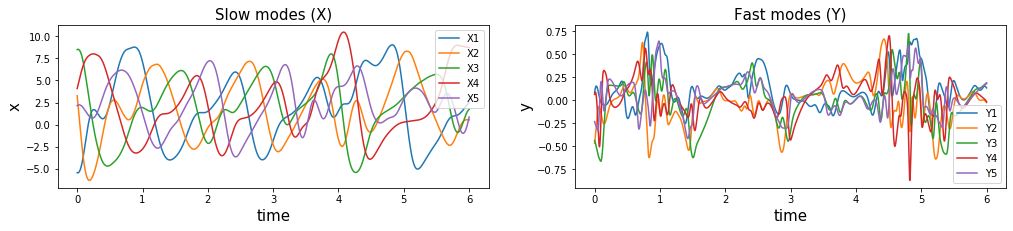

In [3]:
# Plot the L96 system
L96.plot()

We can clearly see the slow/fast behaviour of $X$ and $Y$ respectively.
Next, we compute the subgrid terms $B_k = - \frac{hc}{J} \sum_{j=1}^J Y_{j,k}$. This will be used later as the *labels* for the regression problem.

In [4]:
# Get the X and Y components of the L96 trajectory
X, Y = L96.trajectory['X'], L96.trajectory['Y']

# Get the parameters of the model
h, c, b, F = L96.params

# Compute the effect of Y on X
B = -1*h*c*Y.reshape(-1,K,J).mean(-1)

For the training and test dataset, we won't do a random split this time, but instead take out the last 20% of the data for testing.

In [5]:
train_size = 0.8
nsplit = int(round(num_samples*train_size))
train_X, train_B = X[:nsplit], B[:nsplit]
test_X, test_B = X[nsplit:], B[nsplit:]

Now we are ready to start fitting the data $(X, B)$! As in the previous part, we will consider three models to perform the regression task, namely, linear models, decision trees and neural networks.

## 1. Linear Regression

First, we consider *linear regression* which is the simplest method to solve a regression task. Given a labelled dataset $(X_n, y_n)_{n=1}^N$, this is basically just finding the parameters $\boldsymbol{\beta} = (\beta_0, \beta_1, \ldots, \beta_m)$ such that the linear model

$$f(X; \boldsymbol{\beta}) = \beta_0 + \beta_1 X[1] + \cdots + \beta_m X[m]$$

fits the data as close as possible.

In practice, this can be done by minimizing the *mean square error*:

$$\mathcal{L}(\boldsymbol{\beta}) = \frac1N \sum_{n=1}^N \|y_n - f(X_n; \boldsymbol{\beta})\|^2.$$

As before, we use `scikit-learn` to fit a linear model on the data.

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

We first assume the following linear relationship between $X$ and $B$:

$$B_k = f_k(X_1, \ldots, X_K) := \sum_{l=1}^K \alpha_{kl} X_l + \beta_k, \quad k = 1, \ldots, K$$

between the slow variables $X$ and the subgrid effects $B$, where every components of $X$ are assumed to affect each component of $B$. In `scikit-learn`, the optimal parameters $\{\alpha_{kl}\}_{k,l=1}^K$ and $\{\beta_k\}_{k=1}^K$ can be computed easily using the `fit` method.

In [7]:
# Set up linear model
model_lr = LinearRegression()

# Fit linear model on training data
model_lr.fit(train_X, train_B)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

To visualise how our fitted model performs on the test data, we plot the first four components of the predicted timeseries $\hat{B}_k(t)$ against the true subgrid effects $B_k(t)$ below, where the prediction is based on the fitted linear model $\hat{B}_k(t) = f_k(X_1(t), \ldots, X_K(t))$ for $k = 1, \ldots, K$:

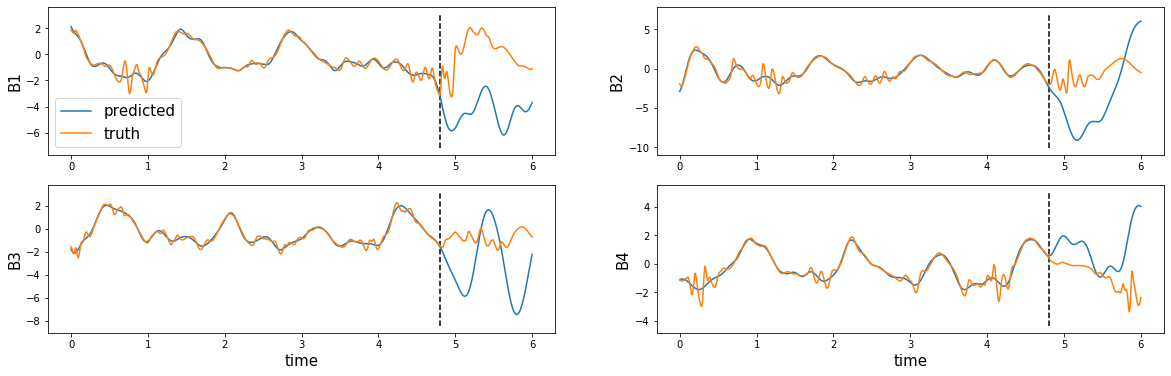

In [8]:
def plot_subgrid(f, X, B, tmax, train_size=0.8, samplesize=4):
    """f is a function that takes an array of size (n_samples, n_features) and outputs
       an array of size (n_samples, n_features)
       X, B are arrays of size (n_samples, n_features)
    """
    Bpred = f(X)
    tspan = np.linspace(0, tmax, X.shape[0])
    nsplit = tmax*train_size
    fig = plt.figure(figsize=(20, 6))
    for i in range(samplesize):
        ax = plt.subplot(2, 2, i+1)
        plt.plot(tspan, Bpred[:,i], label='predicted')
        plt.plot(tspan, B[:,i], label='truth')
        Bmax = np.max(np.stack([Bpred[:,i], B[:,i]]))
        Bmin = np.min(np.stack([Bpred[:,i], B[:,i]]))
        plt.vlines(nsplit, Bmin-1, Bmax+1, linestyles='dashed')
        ax.set_ylabel(f'B{i+1}', fontsize=15)
        if i == 0:
            ax.legend(fontsize=15)
        if i >= samplesize-2:
            ax.set_xlabel('time', fontsize=15)
    plt.show()
    
plot_subgrid(model_lr.predict, X, B, tmax)

The vertical dashed line indicates where the test data starts. We can see clearly that the model has *overfitted*, which means that it performs well on the training set but performs poorly on the test data set. To quantify how well the model fits the data, we use the $R^2$-*coefficient of determination*, which is computed as

$$
R^2 := 1 - \frac{\sum_{n=1}^N \|B_n - f_n(X)\|^2}{\sum_{n=1}^N \|B_n - \bar{B}\|^2},
$$

where $\bar{B} = \frac1N \sum_{n=1}^N B_n$ is the empirical mean. We see that $R^2$ achieves a maximum value of one if the model predicts all of $B_n$ perfectly, zero if it always predicts the empirical mean $\bar{B}$ and negative values if the predictions are very bad.

In `scikit-learn` we compute the $R^2$ score on the test dataset using `r2_score` in `sklearn.metrics`:

In [9]:
from sklearn.metrics import r2_score

Bpred = model_lr.predict(test_X)
R2_lr = r2_score(test_B, Bpred)
print(f"Score for linear regression: {R2_lr}")

Score for linear regression: -43.30435609462053


The result is a strongly negative value, which indicates that the model does not fit the test set well at all, as expected from our plot. Next, we'll see how we can improve this model by selecting only the relevant features instead of using all of $\{X_k\}_{k=1}^K$ to predict $B_k$.

### Feature selection with Lasso (Pronounced: La-soo)

Here, we will look at how to improve our model performance by *reducing* the number of features, also called *feature selection*, in order to avoid overfitting.
Previously, we used all of $\{X_k\}_{k=1}^K$ to predict $B_k$, however, if let's say a component $X_l$ is not that relevant to the determination of $B_k$, then having $X_l$ in the feature space may actually be detrimental to the model prediction as there is danger of fitting the model to noise. In order to avoid this from happening, we wish to select only the relevant features that actually help us to predict $B_k$.

One way to help us do this is by looking at the *correlation* between $B_k$ and the features $X_l$. Given a dataset $(X_n, Y_n)_{n=1}^N$, the *correlation* $\rho_{XY}$ between the variables $X$ and $Y$ is computed as

$$
\rho_{XY} = \frac{\sum_{n=1}^N (X_n - \bar{X})(Y_n - \bar{Y})}{\sqrt{\sum_{n=1}^N(X_n - \bar{X})^2} \sqrt{\sum_{n=1}^N(Y_n - \bar{Y})^2}},
$$

where $\bar{X}$ and $\bar{Y}$ denotes the empirical mean of $X$ and $Y$ respectively.

From this, we see that if $\rho_{XY} > 0$, then an increase in $X$ generally leads to an *increase* in $Y$ (we say that $X$ is *positively correlated* to $Y$) and if $\rho_{XY} < 0$, then an increase in $X$ generally leads to a *decrease* in $Y$ (we say that $X$ is *negatively correlated* to $Y$). When $\rho_{XY}$ is close to zero, then that means that there is no discernible relation between $X$ and $Y$ and we say that $X$ and $Y$ are *not correlated*. Thus, in feature selection, we are looking to eliminate any features that have almost zero correlation with the target variables.

Let's start by computing the correlation between $B_1$ and $X_1, X_2, X_3, X_4, X_5$ and plot its heatmap:

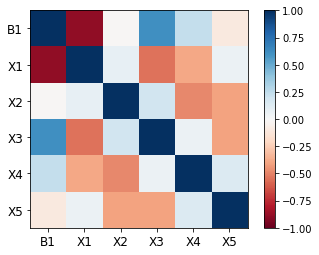

In [10]:
# Concatenate variables of interest: (B1, X1, X2, X3, X4, X5)
m = B[:,0][None]
for i in range(5):
    m = np.concatenate((m, X[:,i][None]), axis=0)
    
# Compute correlation
cov = np.corrcoef(m)

# Plot heatmap
plt.imshow(cov[:6, :6], cmap='RdBu', vmin = -1, vmax = 1)
cb = plt.colorbar()
plt.xticks(range(6), ('B1', 'X1', 'X2', 'X3', 'X4', 'X5'), fontsize=12)
plt.yticks(range(6), ('B1', 'X1', 'X2', 'X3', 'X4', 'X5'), fontsize=12)
plt.show()

If we now look at the first row (or first column, doesn't matter) of the heat map, we see that $B_1$ is strongly negatively correlated with $X_1$ and moderately postively correlated with $X_3$, so we should keep these features. The correlations with the remaining variables $X_2, X_4$ and $X_5$ are almost negligible so it seems to be a good idea to discard them from the feature space.

Now, we can keep doing this and find the relevant variables for all of $B_1, B_2, \ldots, B_K$ but this is going to be pretty tedious. Fortunately, there is a way to automatically extract these relevant features by using a technique called *lasso*, or $\mathcal{l}^1$-*regularization*.

In [11]:
from sklearn.linear_model import Lasso

What lasso does is to *shrink the irrelevant coefficients down to zero* through an additional $\mathcal{l}^1$-penalty term in the loss

$$\mathcal{L}_{lasso}(\boldsymbol{\beta}) = \frac1N \sum_{n=1}^N \|y_n - f(X_n; \boldsymbol{\beta})\|^2 \underbrace{+ \alpha \|\boldsymbol{\beta}\|_{1}}_{\text{penalty term}},$$

for $\alpha > 0$. Since the objective is to *minimize* this loss, clearly the $\mathcal{l}^1$-penalty term biases the coefficients $\boldsymbol{\beta}$ toward smaller values. What is less obvious is that it is capable of driving them down to zero (in contrast to $\mathcal{l}^2$-penalty), thus effectively removing irrelevant features from the feature space!

Now let's fit a lasso model with $\alpha=0.5$

In [12]:
# Set up lasso model 
model_lasso = Lasso(alpha=0.5)

# Fit lasso on training data
model_lasso.fit(train_X, train_B)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

We see which features were eliminated by plotting the learned coefficients $\beta_k$ that are used to predict the label $B_1$:

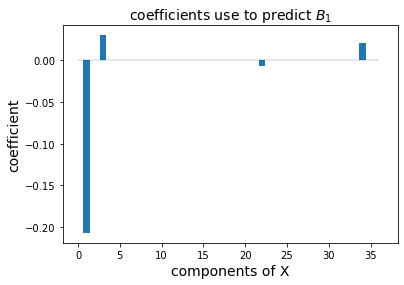

Components of X with non-zero coefficients: [1, 3, 22, 34]


In [13]:
plt.bar(np.arange(1, 37, 1), model_lasso.coef_[0])
plt.hlines(0, xmin=0, xmax=36, linewidth=0.2)
plt.xlabel("components of X", fontsize=14)
plt.ylabel("coefficient", fontsize=14)
plt.title(r"coefficients use to predict $B_1$", fontsize=14)
plt.show()
print(f"Components of X with non-zero coefficients: {[i+1 for i in np.where(model_lasso.coef_[0] != 0)[0]]}")

This is great! We see that the coefficients in front of $X_1$ and $X_3$ are non-zero as expected from our previous observations, in addition to finding out that the variables $X_{22}$ and $X_{34}$ also have an influence on $B_1$! Thus, the resulting model for $B_1$ reads

$$B_1 = \alpha_1 X_1 + \alpha_3 X_3 + \alpha_{22} X_{22} + \alpha_{34} X_{34} + \beta_1.$$

Now let's plot the predicted timeseries $\hat{B}_t = f(X_t)$ using the lasso model as before:

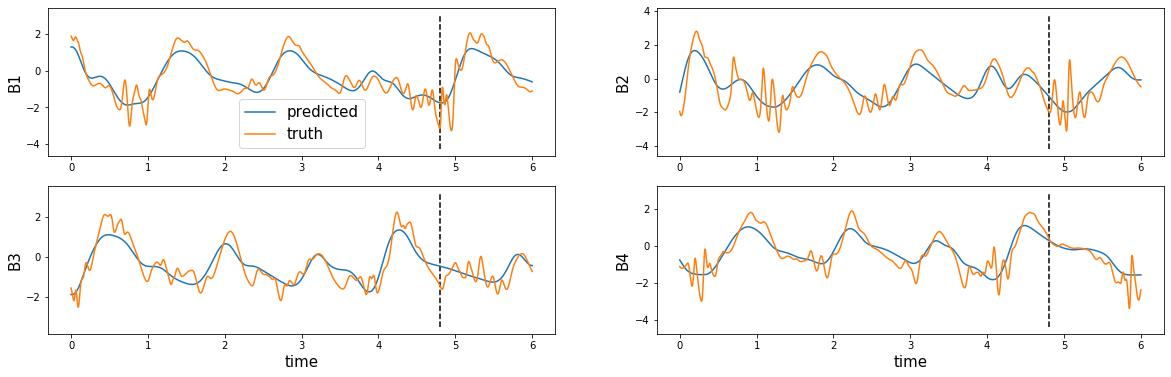

In [14]:
plot_subgrid(model_lasso.predict, X, B, tmax)

Clearly, there is an improvement over our previous predictions and we see that lasso has successfully avoided overfitting! Again, we can quantify this performance using the $R^2$ score.

In [15]:
Bpred = model_lasso.predict(test_X)
R2_lasso = r2_score(test_B, Bpred)
print(f"Score for lasso: {R2_lasso}")

Score for lasso: 0.3835651055848547


Great! This is a much better R2 score than what we saw previously!

__Note:__ If we instead penalize the loss function by an $\mathcal{l}^2$-penalty, we get something called *ridge regression*. Ridge regression helps to improve performance when multi-collinearity is present in the data and also works by shrinking the values of the parameters, but never drives them down to zero like lasso does. If you have time, try also experimenting with ridge regression and see what kind of results you get!

### An alternative model assumption

We will now assume the following simple relationship between the slow variables $X$ and the subgrid effects $B$:

$$B_k = f(X_k) = aX_k + b, \quad \forall k = 1, \ldots, K$$

for fixed constants $a, b$, as assumed in [this blog](https://raspstephan.github.io/blog/lorenz-96-is-too-easy/). In this case, the assumption is that the only variable that affects $B_k$ is $X_k$, and moreover the relationship is universal across all $k = 1, \ldots, K$.
To fit this model, we ravel our dataset (both $X$ and $B$) to get a new dataset of the form:

\begin{align*}
\mathrm{ \small features} \,
\underbrace{
\begin{cases}
\begin{pmatrix}
X_{1,1} & \cdots & X_{1,N} \\
\vdots & \ddots & \vdots \\
X_{K,1} & \cdots & X_{K,N} 
\end{pmatrix} 
\end{cases}
}_{\text{samples}}
\quad
\rightarrow
\quad
\mathrm{\small features} \,
\underbrace{
\begin{cases}
(X_{1,1} \cdots X_{1,N}, \ldots, X_{K,1} \cdots X_{K,N})
\end{cases}
}_{\text{samples}}.
\end{align*}

Now this new training dataset will have a large number of samples, so we also do a random subsampling to keep it the same number.

In [16]:
n_samples, n_features = train_X.shape
indices = np.arange(1, n_samples*n_features)

# Shuffle index set randomly and get the first n_samples indices
np.random.shuffle(indices)
indices = indices[:n_samples]

train_X_ravel, train_B_ravel = np.ravel(train_X)[indices, None], np.ravel(train_B)[indices, None]

print(f"Shape of new training set: {train_X_ravel.shape}")

Shape of new training set: (4800, 1)


We fit a linear model on this new dataset

In [17]:
# Set up linear model
model_lr_simple = LinearRegression()

# Fit to new training data
model_lr_simple.fit(train_X_ravel, train_B_ravel)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

and plot the predictions against the training data:

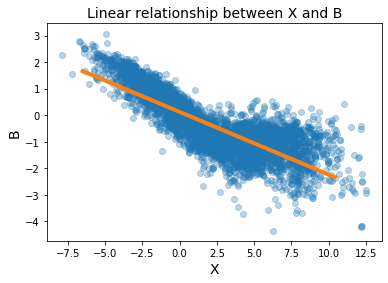

In [18]:
# Get parameters a and b of the simple linear model
a, b = model_lr_simple.coef_[0,0], model_lr_simple.intercept_[0]

# Compute line of best fit
x = np.arange(-6.5, 10.5, 0.1)
y = a * x + b # prediction

# Plot the line against the true data
plt.scatter(train_X_ravel, train_B_ravel, alpha=0.3)
plt.plot(x, y, color='tab:orange', linewidth=4)
plt.xlabel("X", fontsize=14)
plt.ylabel("B", fontsize=14)
plt.title("Linear relationship between X and B", fontsize=14)
plt.show()

We see that the line fits pretty well to the true data and agrees with the plot found in [this original blog](https://raspstephan.github.io/blog/lorenz-96-is-too-easy/)!

Next, we plot the predicted timeseries $\hat{B}_k(t) = f(X_k(t))$ using this simple model (caution: we have to reshape the arguments size from (batch x feature, 1) back to (batch, feature) in order to pass it to `plot_subgrid`, which we do using the `reshape_args` class that we construct below).

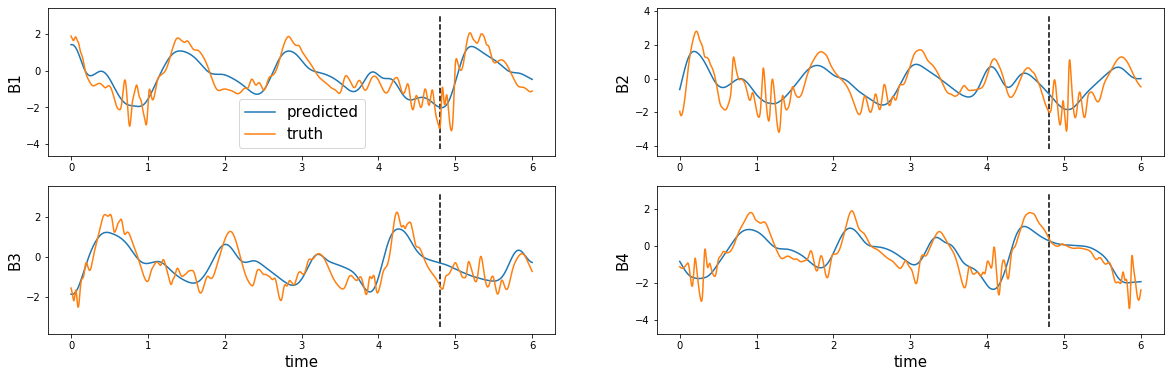

In [19]:
class reshape_args():
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        batchsize, features = X.shape
        X_ravel = np.ravel(X).reshape(batchsize*features, 1)
        ypred = self.model.predict(X_ravel)
        return ypred.reshape(batchsize, features)

model_lr_simple = reshape_args(model_lr_simple)
plot_subgrid(model_lr_simple.predict, X, B, tmax)

The plots look pretty good but how does this compare with the lasso model that we considered earlier?

In [20]:
Bpred = model_lr_simple.predict(test_X)
R2_lr_simple = r2_score(test_B, Bpred)
print(f"Score for simple model: {R2_lr_simple}")

Score for simple model: 0.40278700300435333


We observe that the model performs similarly to lasso or even slightly better depending on the run!
What this means is that the assumptions imposed in this simple model is pretty good and therefore it's sufficient to model $B_k$ using just $X_k$!

<!---This might be confusing as earlier, we saw in the heatmap that $B_1$ is strongly correlated with both $X_1$ *and* $X_3$ (and possibly also $X_{22}$ and $X_{34}$). So how is it that the assumption that $B_1$ only depends on $X_1$ better? To answer this, if we go back to the heatmap, we see that $X_1$ is also pretty strongly correlated with $X_3$. So the fact that $B_1$ is correlated with $X_3$ may only be an artifact of the fact that $X_1$ and $X_3$ are correlated! When constructing a statistical model, it is best to have the features independent of one another, which explains why the simpler model does better (this problem is called *multicollinearity* and you can read more about it [here](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)).--->

## 2. Decision Tree Regressors

Next, we consider decision trees and random forests, which is also capable of solving regression tasks and not just classification.
(Give example)
Again, we won't delve into how these trees are constructed to save time, but you can find out more [in this video](https://www.youtube.com/watch?v=g9c66TUylZ4) if you are interested!

In `scikit-learn`, we can perform decision tree/random forest regression using `DecisionTreeRegressor` and `RandomForestRegressor`:

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

The decision tree we will consider takes in as input features the entire $K$-dimensional vector $X = (X_1, \ldots, X_K)$ and get the $K$-dimensional vector $B = (B_1, \ldots, B_K)$ as outputs for the purpose of illustration, even though we saw earlier that doing this is not a great idea as it leads to overfitting. Later, we will see how this performs on the ravelled dataset. As usual, we fit a decision tree regressor on the training data using the `fit` method.

In [22]:
# Set up decision tree
model_dt = DecisionTreeRegressor()

# Fit decision tree
model_dt.fit(train_X, train_B)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Then, we plot the prediction below (reminder to also plot decision tree):

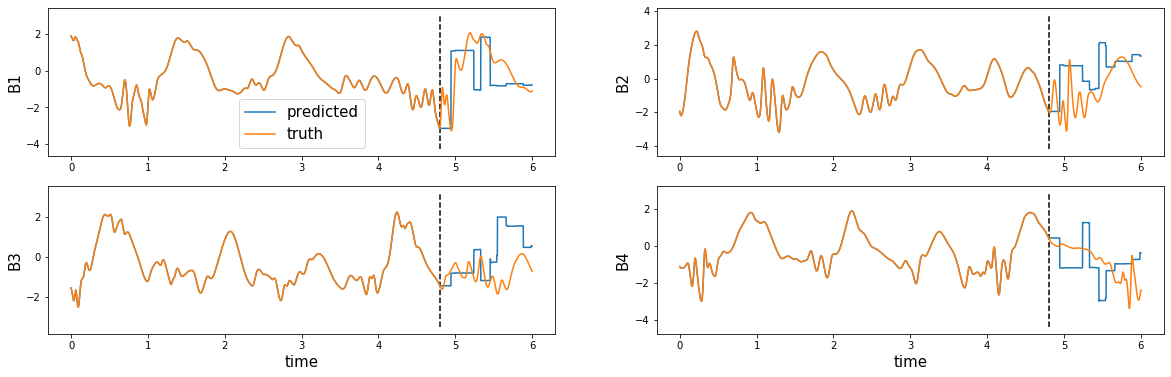

In [23]:
plot_subgrid(model_dt.predict, X, B, tmax)

We see that the model has overfitted quite considerably (in fact predictions on the training set looks almost perfect!) since we took all of $(X_k)_{k=1}^K$ as features. Below, we show the $R^2$ score for this model.

In [24]:
Bpred = model_dt.predict(test_X)
R2_dt = r2_score(test_B, Bpred)
print(f"Score for decision tree: {R2_dt}")

Score for decision tree: -1.9836960587891659


The result is not great as expected, however it is better than the linear regression model. Next, let's see if we can improve this by using random forests.

### Random forest regression

We saw earlier that regressing with decision trees lead to considerable overfitting but what about random forests?

In [25]:
# May take 20 ~ 30 seconds to compute
model_rf = RandomForestRegressor(max_depth=10)
model_rf.fit(train_X, train_B)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

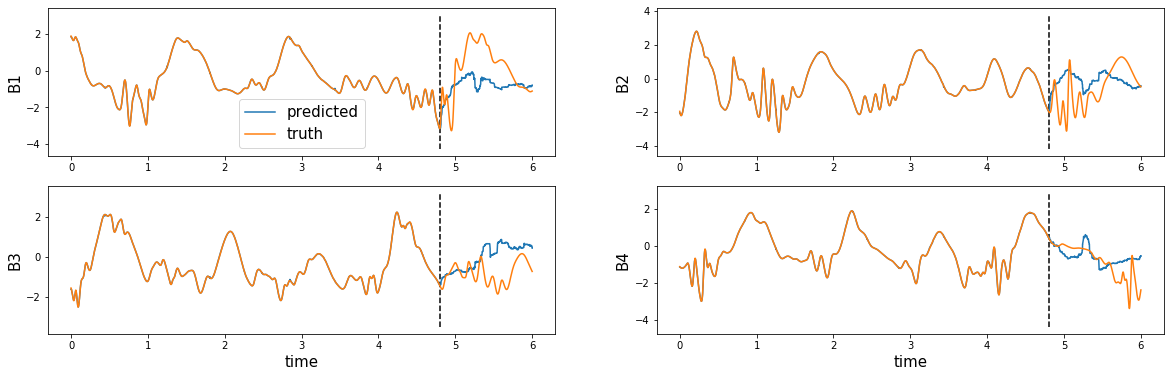

In [26]:
# Plot predictions
plot_subgrid(model_rf.predict, X, B, tmax)

The random forest still overfits quite heavily but the prediction on the test set maybe looks a little better (it certainly seems less jagged)? Let's see whether that is indeed the case by computing its $R^2$ score.

In [27]:
Bpred = model_rf.predict(test_X)
R2_rf = r2_score(test_B, Bpred)
print(f"Score for lasso: {R2_rf}")

Score for lasso: -0.7623880515326241


As expected, the performance using random forests is better than that using deicision trees!

### Alternative model assumption

Finally, let's fit a second random forest model on the ravelled dataset so that it fits a model of the form

$$B_k = f(X_k), \quad k = 1, \ldots, K,$$

where $f$ is independent of the indices $k$.

In [28]:
# Fit a second random forest model on ravelled dataset
model_rf_2 = RandomForestRegressor(max_depth=10)
model_rf_2.fit(train_X_ravel, train_B_ravel.squeeze())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

We plot the predictions against the true data below:

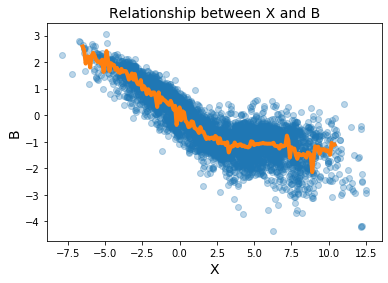

In [29]:
# Compute prediction
x = np.arange(-6.5, 10.5, 0.1)
y = model_rf_2.predict(x[:,None]) # prediction

# Plot the line against the true data
plt.scatter(train_X_ravel, train_B_ravel, alpha=0.3)
plt.plot(x, y, color='tab:orange', linewidth=4)
plt.xlabel("X", fontsize=14)
plt.ylabel("B", fontsize=14)
plt.title("Relationship between X and B", fontsize=14)
plt.show()

and observe that the random forest has successfully captured the 'boomerang' shape of the data distribution!

Now, we plot the predicted timeseries $\hat{B}_k(t) = f(B_k(t))$:

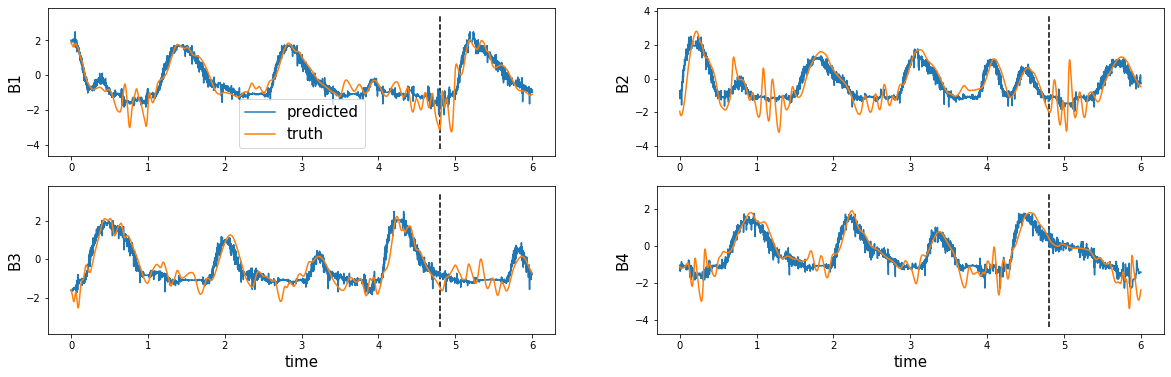

In [30]:
model_rf_2 = reshape_args(model_rf_2)
plot_subgrid(model_rf_2.predict, X, B, tmax)

and see that it generalises much better since we have removed the redundant features! Finally, we evaluate the performance using the $R^2$ score:

In [31]:
Bpred = model_rf_2.predict(test_X)
R2_rf_2 = r2_score(test_B, Bpred)
print(f"Score for random forest: {R2_rf_2}")

Score for random forest: 0.46603159499733743


We see that the result is better than the linear regression model since the random forest is able to capture the nonlinear 'boomerang' shape of the data distribution that the linear model couldn't capture!

## 3. Neural Networks

Finally, we look at how neural networks perform on this task. The neural network architecture that is used for regression tasks is the same as in classification, except that

1. we don't include a sigmoid activation in the output layer, and
2. the loss function is usually the mean squared error instead of the cross-entropy loss.

Again, we will consider two model assumptions

1. $B_k = f_k(X_1, \ldots, X_K)$
2. $B_k = f(X_k)$

for all $k = 1, \ldots, K$ and see how both of them compare to the previous methods.

In [32]:
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization

We first consider the first setting where the neural network models the function $B_k = f_k(X_1, \ldots, X_K)$. The procedure for doing this is almost identical to the classification case we saw in the previous part of the tutorial so have a look at that if you're not familiar.

In [33]:
# Introduce normalizing layer
Normalize = Normalization()
Normalize.adapt(train_X)

# Set up neural network
model_nn = Sequential([
    Input(shape=(K,)),
    Normalize,
    Dense(300, activation='relu'),
    Dense(300, activation='relu'),
    Dense(300, activation='relu'),
    Dense(K)])

# Choose loss = mean squared error and optimizer = Adam
loss_fn = keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model_nn.compile(loss=loss_fn, optimizer=opt)

# Show model summary
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 36)                73        
_________________________________________________________________
dense (Dense)                (None, 300)               11100     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 36)                10836     
Total params: 202,609
Trainable params: 202,536
Non-trainable params: 73
_________________________________________________________________


In [34]:
# Fit neural network on the training data
model_nn.fit(train_X, train_B, epochs=20)

Epoch 1/20
150/150 [==============================] - 1s 8ms/step - loss: 0.1864
Epoch 2/20
150/150 [==============================] - 1s 7ms/step - loss: 0.0593
Epoch 3/20
150/150 [==============================] - 1s 4ms/step - loss: 0.0451
Epoch 4/20
150/150 [==============================] - 1s 4ms/step - loss: 0.0356
Epoch 5/20
150/150 [==============================] - 1s 5ms/step - loss: 0.0280
Epoch 6/20
150/150 [==============================] - 1s 5ms/step - loss: 0.0230
Epoch 7/20
150/150 [==============================] - 1s 5ms/step - loss: 0.0190
Epoch 8/20
150/150 [==============================] - 1s 5ms/step - loss: 0.0156
Epoch 9/20
150/150 [==============================] - 1s 5ms/step - loss: 0.0125
Epoch 10/20
150/150 [==============================] - 1s 5ms/step - loss: 0.0112
Epoch 11/20
150/150 [==============================] - 1s 6ms/step - loss: 0.0098
Epoch 12/20
150/150 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 13/20
150/150 [====

Now let's see how our prediction looks based on this fitted model!

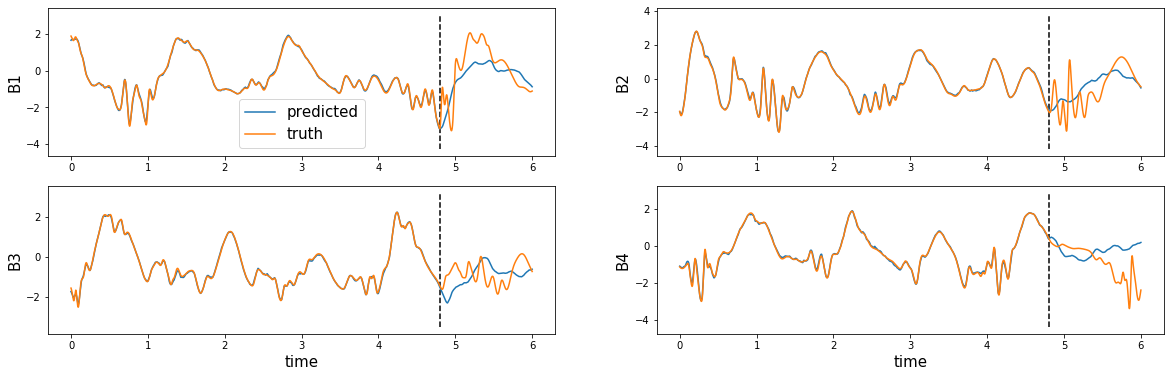

In [35]:
plot_subgrid(model_nn, X, B, tmax)

We definitely see an overfitting but the predictions on the test set doesn't seem so horrible. Let's compute the $R^2$ score to quantify its performance.

In [36]:
B_pred = model_nn(test_X)
R2_nn = r2_score(test_B, B_pred)
print(f"Score for neural network: {R2_nn}")

Score for neural network: -0.6439567060897282


The result is still negative, but it's not as bad as the values obtained by linear regression and decision trees under this model assumption!

Now let's see if we can improve this with the simpler model assumption $B_k = f(X_k)$.

In [37]:
# Introduce normalizing layer
Normalize = Normalization()
Normalize.adapt(train_X_ravel)

# Set up model
model_nn_2 = Sequential([
    Input(shape=(1,)),
    Normalize,
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)])

# Choose loss to be mean squared error and optimizer to be Adam
loss_fn = keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model_nn_2.compile(loss=loss_fn, optimizer='adam')

# Show model summary
model_nn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 254
Trainable params: 251
Non-trainable params: 3
_________________________________________________________________


In [38]:
# Fit model on ravelled training set
model_nn_2.fit(train_X_ravel, train_B_ravel, epochs=20)

Epoch 1/20
150/150 [==============================] - 0s 2ms/step - loss: 0.5858
Epoch 2/20
150/150 [==============================] - 1s 4ms/step - loss: 0.2806
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.2709
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.2701
Epoch 5/20
150/150 [==============================] - 0s 3ms/step - loss: 0.2704
Epoch 6/20
150/150 [==============================] - 1s 4ms/step - loss: 0.2693
Epoch 7/20
150/150 [==============================] - 1s 5ms/step - loss: 0.2699
Epoch 8/20
150/150 [==============================] - 1s 4ms/step - loss: 0.2694
Epoch 9/20
150/150 [==============================] - 0s 3ms/step - loss: 0.2693
Epoch 10/20
150/150 [==============================] - 0s 3ms/step - loss: 0.2708
Epoch 11/20
150/150 [==============================] - 0s 3ms/step - loss: 0.2689
Epoch 12/20
150/150 [==============================] - 1s 4ms/step - loss: 0.2698
Epoch 13/20
150/150 [====

Below, we plot how the fitted neural network predicts the relationship between $X$ and $B$.

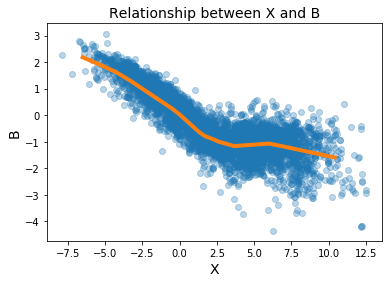

In [39]:
# Compute prediction
x = np.arange(-6.5, 10.5, 0.1)
y = model_nn_2(x) # prediction

# Plot the line against the true data
plt.scatter(train_X_ravel, train_B_ravel, alpha=0.3)
plt.plot(x, y, color='tab:orange', linewidth=4)
plt.xlabel("X", fontsize=14)
plt.ylabel("B", fontsize=14)
plt.title("Relationship between X and B", fontsize=14)
plt.show()

This looks great! It captures the 'boomerang' shape that is present in the data perfectly, without all the jaggedness we saw when we fitted a random forest. We also plot below the predicted timeseries $\hat{B}_k(t) = f(X_k(t))$ based on this model.

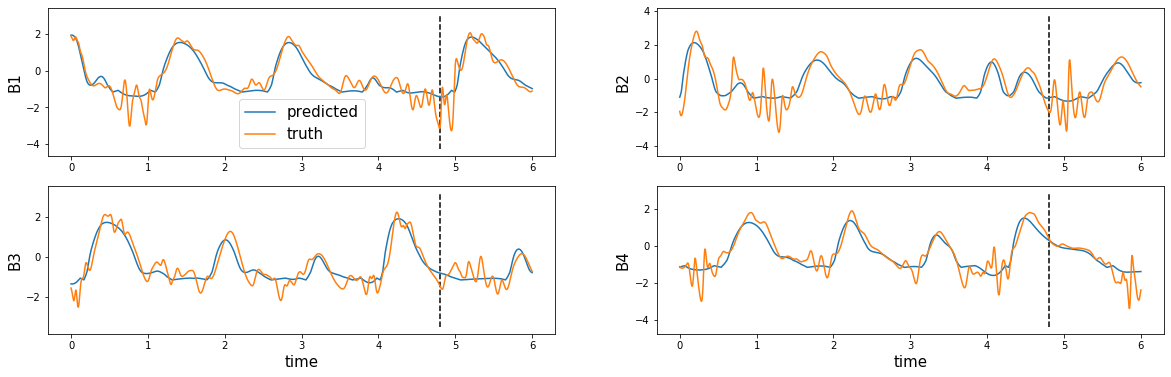

In [40]:
class reshape_args_nn():
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        batchsize, features = X.shape
        X_ravel = np.ravel(X).reshape(batchsize*features, 1)
        ypred = self.model(X_ravel).numpy()
        return ypred.reshape(batchsize, features)

model_nn_2 = reshape_args_nn(model_nn_2)
plot_subgrid(model_nn_2.predict, X, B, tmax)

It's hard to judge with our eyes at this point whether this looks better or worse than the previous cases under this model assumption, so we compute the $R^2$ score to quantify the performance precisely.

In [41]:
B_pred = model_nn_2.predict(test_X)
R2_nn_simple = r2_score(test_B, B_pred)
print(f"Score for simple neural network: {R2_nn_simple}")

Score for simple neural network: 0.5021724928074941


We have a winner here! The performance is slightly better than the random forest model and this may be due to the lack of jaggedness that was present in the predictions based on the random forest.
